# TODO

In [1]:
# TODO:
#   WorldDQNAgentSettingsView: create_dqn_agent:
#       1) Error message when exception error occurs
#       2) Errpr message when dqn_agent alreay exists

# TODO 230408:
#   A) Allow World to maintain a current_opponent and a list of possible opponents.
#   B1) Allow World to maintain a current_agent and a list of possible (trainable) agents. [HOLD]
#   B2) Automatically keep "old" version of "current_agent" after training and put it in the list of possible opponents.
#   C) Better name for the file 'all_rows.json'
#   D) A window with tabs "Train", "Evaluate", "Deploy", etc [HOLD]
#   E) Let all_rows.json have columns for players' rewards.
#   F) Define function to regroup all_row.json by game by move. [HOLD]

# TODO 230411:
#   A) Need to save world's DQN_Agent_Config ??? [HOLD]
#   B) Need to save world's RL_Trainer_Config ??? [HOLD]

# World

A World folder maintains the following files and subfolders:
* game_settings.json
* zero or more agent folders with name \<agent_name\> of your choice:
    1. \<agent_name\>.pth
    1. fig.png
    1. log.txt
    1. performance.csv
    1. all_rows.json
    1. old_\<agent_name\>.pth [HOLD]

The game_settings defines the game that all the agents will be playing.
It should not be modified once any agent is created.

In [2]:
import os
import sys
import argparse
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
from datetime import datetime
from pytz import timezone
from collections import OrderedDict
import more_itertools as mit
import pandas as pd
import random
import re # regular expression

from enum import Enum 

from traitlets.traitlets import HasTraits, Int, Unicode, default

from typing import List, Set, Dict, Tuple, Any

import importlib

In [3]:
# define gui
#!pip install panel
from bokeh.core.validation import check

import panel as pn
from panel.interact import interact, fixed
from panel import widgets
import param

pn.extension(raw_css=["""
div.orange_border_table + table * {
  border: 1px solid orange;
}
"""])

In [4]:
%cd /content/drive/MyDrive/A2023
%ls
#%rm -rf /content/drive/MyDrive/A2023/rlcard
#!git clone -b dev https://github.com/billh0420/rlcard.git

/content/drive/MyDrive/A2023
GinRummy2023.ipynb  GradioExample.ipynb     rlcard/     Trajectory_World/
Gin_Rummy_World/    results_gin_rummy_dqn/  Taxi.ipynb


# Change to directory Gin_Rummy_World

In [5]:
%cd /content/drive/MyDrive/A2023/Gin_Rummy_World
%ls

/content/drive/MyDrive/A2023/Gin_Rummy_World
'Demo Panel.ipynb'   game_settings.json     gin_rummy_lib/
 dqn_agent/          GinRummy230409.ipynb   __pycache__/


# import rlcard

In [24]:
%ls
for item in sys.path:
    print(item)

'Demo Panel.ipynb'   game_settings.json     gin_rummy_lib/
 dqn_agent/          GinRummy230409.ipynb   __pycache__/
/content
/env/python
/usr/lib/python39.zip
/usr/lib/python3.9
/usr/lib/python3.9/lib-dynload

/usr/local/lib/python3.9/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.9/dist-packages/IPython/extensions
/root/.ipython
/content/drive/MyDrive/A2023/rlcard
/content/drive/MyDrive/A2023/Gin_Rummy_World/gin_rummy_lib


In [7]:
def do_import_rlcard():
    abs_rlcard_path = '/content/drive/MyDrive/A2023/rlcard'
    if os.path.exists(abs_rlcard_path):
        if not abs_rlcard_path in sys.path:
            sys.path.append(abs_rlcard_path)
            import rlcard
            import rlcard as rlcard
            print('imported rlcard')
        else:
            print('rlcard already imported')
    else:
        print(f'Cannot import rlcard; cannot find directory: {abs_rlcard_path}')
do_import_rlcard()

imported rlcard


In [8]:
import rlcard
from rlcard.agents import RandomAgent
from rlcard.utils import get_device, set_seed, tournament, reorganize, Logger, plot_curve
from rlcard.agents import DQNAgent
from rlcard.models.gin_rummy_rule_models import GinRummyNoviceRuleAgent

from rlcard.agents.dqn_agent import Memory
from rlcard.agents.dqn_agent import Estimator

from rlcard.games.gin_rummy.player import GinRummyPlayer
from rlcard.games.gin_rummy.game import GinRummyGame
from rlcard.games.gin_rummy.utils.action_event import ActionEvent, DiscardAction
from rlcard.games.gin_rummy.utils.action_event import KnockAction, GinAction, DeclareDeadHandAction

from rlcard.games.gin_rummy.utils.scorers import GinRummyScorer
from rlcard.games.gin_rummy.utils.settings import Setting, Settings, DealerForRound

from rlcard.games.gin_rummy.utils.action_event import draw_card_action_id, pick_up_discard_action_id

import rlcard.games.gin_rummy.utils.utils as utils
import rlcard.games.gin_rummy.utils.melding as melding

from rlcard.games.gin_rummy.utils.thinker import Thinker

from rlcard.games.base import Card

from rlcard.envs.gin_rummy import GinRummyEnv

from rlcard.agents import NFSPAgent

import rlcard as rlcard # NOTE: don't know why this is needed; don't know why it has to be placed last

# Import from gin_rummy_lib

In [23]:
if not '/content/drive/MyDrive/A2023/Gin_Rummy_World/gin_rummy_lib' in sys.path:
    sys.path.append('/content/drive/MyDrive/A2023/Gin_Rummy_World/gin_rummy_lib')
from util import to_int_list
from util import sortByRankBySuit
from DQNAgentConfig import DQNAgentConfig
from GameSettingsPane import GameSettingsPane

from util import to_int_list
from util import sortByRankBySuit
from GameSettingsPane import GameSettingsPane
from DQNAgentConfig import DQNAgentConfig
from RLTrainerConfig import RLTrainerConfig
from RLTrainer import RLTrainer
from GinRummyScorer230402 import GinRummyScorer230402
from GameObserver import GameObserver
from GinRummyRookie01RuleAgent import GinRummyRookie01RuleAgent
from GameObserver import GameObserver
from GameReviewer import GameReviewer
from World import World
from DQNAgentPane import DQNAgentPane
from TrainerPane import TrainerPane
from ReviewPlayWindow import ReviewPlayWindow
from WorldGameSettingsView import WorldGameSettingsView
from WorldDQNAgentSettingsView import WorldDQNAgentSettingsView
from WorldRLTrainerSettingsView import WorldRLTrainerSettingsView
from TrainingResultsWindow import TrainingResultsWindow
from ReviewMatchGamesWindow import ReviewMatchGamesWindow

from util import get_current_time

In [10]:
# from gin_rummy_lib.util import to_int_list
# from gin_rummy_lib.util import sortByRankBySuit
# from gin_rummy_lib.GameSettingsPane import GameSettingsPane
# from gin_rummy_lib.DQNAgentConfig import DQNAgentConfig
# from gin_rummy_lib.RLTrainerConfig import RLTrainerConfig
# from gin_rummy_lib.RLTrainer import RLTrainer
# from gin_rummy_lib.GinRummyScorer230402 import GinRummyScorer230402
# from gin_rummy_lib.GameObserver import GameObserver
# from gin_rummy_lib.GinRummyRookie01RuleAgent import GinRummyRookie01RuleAgent
# from gin_rummy_lib.GameObserver import GameObserver
# from gin_rummy_lib.GameReviewer import GameReviewer
# from gin_rummy_lib.World import World
# from gin_rummy_lib.DQNAgentPane import DQNAgentPane
# from gin_rummy_lib.TrainerPane import TrainerPane
# from gin_rummy_lib.ReviewPlayWindow import ReviewPlayWindow
# from gin_rummy_lib.WorldGameSettingsView import WorldGameSettingsView
# from gin_rummy_lib.WorldDQNAgentSettingsView import WorldDQNAgentSettingsView
# from gin_rummy_lib.WorldRLTrainerSettingsView import WorldRLTrainerSettingsView
# from gin_rummy_lib.TrainingResultsWindow import TrainingResultsWindow
# from gin_rummy_lib.ReviewMatchGamesWindow import ReviewMatchGamesWindow

# from gin_rummy_lib.util import get_current_time

In [11]:
css_log_widget_box = '''
.bk.log-widget-box {
  color: #ffffff;
  background: #000000;
  border: 1px black solid;
}
'''

pn.extension(raw_css=[css_log_widget_box])
pn.extension('tabulator')

# Final Version (Keep) 230407

In [12]:
# Step 1 (one time only)
# Creaate an empty directory for your world.
# For example, create a directory with the name "Gin_Rummy_World"
# This directory will hold all the files that are used in your training sessions.
# This is done one time only.

In [13]:
# Step 2 (always done to get handle on the world with your choice of name.)

# Open world.
#
# This is done each time you want to do something with your agents.
# Here the world is called 'gin_rummy_world'. You can call it simply 'world' if you wish.
#
# If you do not specify the world_dir, then the current working directory is used.
# If you specify its directory, then it must exists else a crash will result.
# Example: gin_rummy_world = World(world_dir='../results_gin_rummy_dqn')
#
# Note: The world variable is the only variable that is allocated in these steps.
#       I am trying to minimize the creation of other named variables (e.g. views and windows).
#
# The world_dir will hold the following:
#   1) The file game_settings.json (It will be automatically created in step 3 if it doesn't exist).
#   2) The directory whose name is the agent name (It will be automatically created when the agent is created).
#       This directory holds the following files:
#       a) the agent pth file (modified by training it in step 6);
#       b) the file all_rows.json used by the ShowReviewMatchGamesWindow;
#       c) the file log.txt created by play_train_match in step 6;
#       d) the file fig.png created by play_train_match in step 6;
#       e) the file performance.csv created by play_train_match in step 6.

gin_rummy_world = World() # Using current directory as world_dir

--> Running on the CPU


In [14]:
# Step 3 (optional)
# Use WorldGameSettingsView to configure game settings (one time only)
# After you create your first training agent in the next step, you should not change the game settings.
# The agent assumes that it is playing with the game settings that existed when it was created.

WorldGameSettingsView(world=gin_rummy_world).view

Row
    [0] Column(margin=5, name='WorldGameSettingsView', width=300)
        [0] StaticText(value='<b>WorldGameSettingsView<...)
        [1] Select(name='Dealer for round', options=OrderedDict([('0', ...]), value=2)
        [2] IntSlider(end=52, name='Stockpile dead c..., value=2)
        [3] IntSlider(end=50, name='Going out deadwood c..., value=10)
        [4] IntSlider(end=52, name='Max drawn card count', value=52)
        [5] IntSlider(end=200, name='Max move count', value=60)
        [6] Checkbox(name='Is allowed knock', value=True)
        [7] Checkbox(name='Is allowed gin', value=True)
        [8] Checkbox(name='Is allowed pick u..., value=True)
        [9] Checkbox(name='Is allowed to d...)
        [10] Checkbox(name='Is always knock')
        [11] Checkbox(name='Is south never knocks')
    [1] ParamMethod(method, _pane=Column)

In [15]:
# Step 4 (optional)
# Use WorldDQNAgentSettingsView to create your training agent (one time only)
# You adjust the settings and hit the "Create DQN Agent" button.
# If an agent with the chosen name already exists.
# You will get a message on whether you were successful or not (not implemented).

WorldDQNAgentSettingsView(world=gin_rummy_world).view

Row
    [0] Param(WorldDQNAgentSettingsView, widgets={'replay_memory_size': <cl...})
    [1] ParamMethod(method, _pane=Column)

In [16]:
# Step 5 (optional)
# Use WorldRLTrainerSettingsView to set trainer settings (multiple times except for changing algorithm)

WorldRLTrainerSettingsView(world=gin_rummy_world).view

Row
    [0] Column(margin=5, name='WorldRLTrainerSettingsVie..., width=300)
        [0] StaticText(value='<b>WorldRLTrainerSettings...)
        [1] Select(name='Algorithm', options=OrderedDict([('dqn', ...]), value='dqn')
        [2] IntSlider(end=20000, name='Num episodes', value=20000)
        [3] IntSlider(end=100, name='Num eval games', value=100)
        [4] IntSlider(end=1000, name='Evaluate every', value=1000)
    [1] ParamMethod(method, _pane=Column)

In [17]:
# Step 6 (optional)
# Run training session (long)

#gin_rummy_world.play_train_match()

TrainingResultsWindow(background='green', width_policy='max')
    [0] Row
        [0] Column(margin=[0, 10, 10, 10], width_policy='max')
            [0] Markdown(str)
            [1] Column(css_classes=['log-widget-box'], height=400, scroll=True, width_policy='max')
                [0] Str(str)
        [1] Column(margin=[0, 10, 10, 10])
            [0] Markdown(str)
            [1] PNG(str, width=400)
    [1] Column(margin=[0, 10, 10, 10])
        [0] Markdown(str)
        [1] Tabulator(height=400, layout='fit_data_stretch', value=    episode  r...)
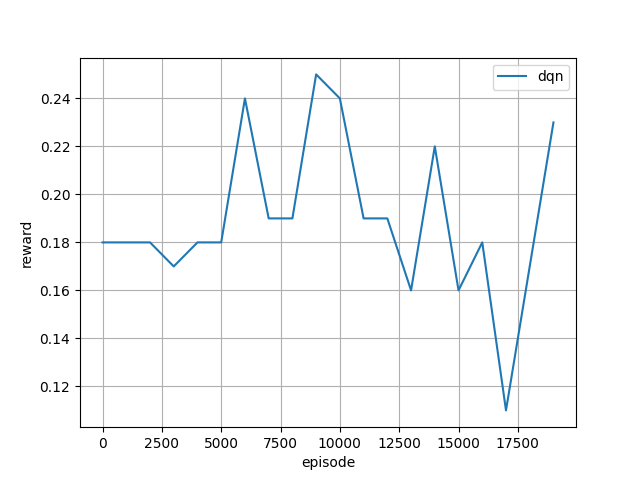

In [18]:
# Step 7 (optional)
# Use TrainingResultsWindow to see results of training (optional)
# Repeat steps 5, 6, 7 as often as you want. Of course, step 5 and 7 will be optional.

TrainingResultsWindow(world=gin_rummy_world)

In [19]:
# Step 8 (optional)
# Use ReviewMatchGamesWindow to review how well the dqn_agent is doing (optional)
# Note that 0 <= max_review_episodes <= 1000.
# Repeat steps 5 trough 8.

ReviewMatchGamesWindow(world=gin_rummy_world)

ReviewMatchGamesWindow(dynamic=True, height=800)
    [0] ReviewPlayWindow(background='green')
        [0] ReviewPlayPane(margin=5)
            [0] Markdown(str)
            [1] PlayMatchControl
                [0] Button(margin=[20, 0, 0, 0], name='Play match', width=140)
                [1] IntInput(end=1000, margin=[0, 0, 0, 10], name='max episodes', start=0, value=30, width=100)
                [2] Markdown(None)
            [2] SelectByGroups(groups={'Default': ['None'], ...}, name='Filter by groups', value='None', width=550)
            [3] IntSlider(end=-1, max_width=600, name='row')
            [4] DiscretePlayer(interval=2000, max_width=600, name='Row', value=0, value_throttled=0)
            [5] GamePane(str)
            [6] InfoTablePane(str)
    [1] DQNAgentPane(str, width=1200)
    [2] TrainerPane(str, width=1200)
    [3] GameSettingsPane(width=1200)
        [0] Markdown(str)
        [1] Row
            [0] Markdown(str)
            [1] Markdown(str)

# Extra try out

In [20]:
game_settings = Settings()
game_settings.print_settings()
default_game_settings = Setting.default_setting()
beta = dict((k.value, v) for (k, v) in default_game_settings.items())
print(beta)
df = pd.DataFrame([beta])
pn.widgets.Tabulator(df)

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=2
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
max_move_count=200
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False
{'dealer_for_round': <DealerForRound.Random: 2>, 'stockpile_dead_card_count': 2, 'going_out_deadwood_count': 10, 'max_drawn_card_count': 52, 'max_move_count': 200, 'is_allowed_knock': True, 'is_allowed_gin': True, 'is_allowed_pick_up_discard': True, 'is_allowed_to_discard_picked_up_card': False, 'is_always_knock': False, 'is_south_never_knocks': False}


Tabulator(value=   dealer_for_round  ...)

In [21]:
# Python links
m = pn.pane.Markdown("")
t = pn.widgets.TextInput()

def callback(target, event):
    if event.new == "run":
        #rlTrainer.train()
        #gin_rummy_world.play_review_match(max_review_episodes=100)
        pass
    target.object = event.new.upper() + '!!!'

t.link(m, callbacks={'value': callback})
t.value="Some text"

pn.Row(t, m)

Row
    [0] TextInput(value='Some text')
    [1] Markdown(str)

In [22]:
import asyncio
button2 = pn.widgets.Button(name='Run increment i')
text2 = pn.widgets.StaticText()
def run_it2(event):
    text2.value = f'Running {event.new}'
    for episode in range(1, 1000):
        if episode % 100 == 0:
            text2.value = f'episode={episode}'
        gin_rummy_world.play_review_match(max_review_episodes=1)
        #asyncio.sleep(5)
    text2.value = f'Finished {event.new}'

button2.on_click(run_it2)
pn.Row(button2, text2)

Row
    [0] Button(name='Run increment i')
    [1] StaticText()